In [3]:
import math
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random

import daft
from causalgraphicalmodels import CausalGraphicalModel

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, Predictive, log_likelihood, NUTS, MCMC
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

8h1



In [4]:
tulips = pd.read_csv('../data/tulips.csv', sep=';')
display(tulips.sample(3))
tulips.describe()

,bed,water,shade,blooms
13,b,2,2,124.99
3,a,2,1,183.47
12,b,2,1,213.13


,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [5]:
tulips.bed.value_counts(dropna=False)

c    9
b    9
a    9
Name: bed, dtype: int64

In [6]:
d = tulips
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()
d['bed_idx'] = pd.Categorical(d.bed).codes

In [7]:
def model(water_cent, shade_cent, bed_idx, blooms_std=None):
    n_bed = len(set(bed_idx))
    a = numpyro.sample("a", dist.Normal(0.5, 0.25))
    a_bed = numpyro.sample("a_bed", dist.Normal(0, 5).expand([n_bed]))

    bw = numpyro.sample("bw", dist.Normal(0, 0.25))
    bs = numpyro.sample("bs", dist.Normal(0, 0.25))
    bws = numpyro.sample("bws", dist.Normal(0, 0.25))
    mu = a + a_bed[bed_idx] + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)

data = dict(
    water_cent=d.water_cent.values,
    shade_cent=d.shade_cent.values,
    bed_idx=d.bed_idx.values,
    blooms_std=d.blooms_std.values
)
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az_1 = az.from_dict({}, sample_stats={"log_likelihood": logprob["blooms_std"][None, ...]})
az.waic(az_1, scale="deviance")

sample: 100%|██████████| 1500/1500 [00:06<00:00, 239.80it/s, 15 steps of size 9.77e-02. acc. prob=0.94]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.50      0.25      0.50      0.07      0.90    182.02      1.00
  a_bed[0]     -0.23      0.25     -0.24     -0.60      0.24    182.33      1.00
  a_bed[1]     -0.11      0.25     -0.11     -0.48      0.35    183.11      1.00
  a_bed[2]     -0.09      0.25     -0.10     -0.49      0.34    185.03      1.00
        bs     -0.11      0.03     -0.11     -0.17     -0.07    845.66      1.00
        bw      0.21      0.03      0.21      0.16      0.26    654.10      1.00
       bws     -0.14      0.04     -0.14     -0.20     -0.08    763.13      1.00
     sigma      0.13      0.02      0.13      0.10      0.16    511.32      1.00

Number of divergences: 0


Computed from 1000 by 27 log-likelihood matrix

              Estimate       SE
deviance_waic   -27.95     6.48
p_waic            6.01        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [8]:
def model(water_cent, shade_cent, blooms_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 0.25))

    bw = numpyro.sample("bw", dist.Normal(0, 0.25))
    bs = numpyro.sample("bs", dist.Normal(0, 0.25))
    bws = numpyro.sample("bws", dist.Normal(0, 0.25))
    mu = a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)

data = dict(
    water_cent=d.water_cent.values,
    shade_cent=d.shade_cent.values,
    blooms_std=d.blooms_std.values
)
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az_2 = az.from_dict({}, sample_stats={"log_likelihood": logprob["blooms_std"][None, ...]})
az.waic(az_2, scale="deviance")

sample: 100%|██████████| 1500/1500 [00:05<00:00, 271.95it/s, 7 steps of size 6.29e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.36      0.03      0.36      0.32      0.41   1035.39      1.00
        bs     -0.11      0.03     -0.11     -0.16     -0.05   1060.57      1.00
        bw      0.21      0.03      0.21      0.15      0.26   1201.81      1.00
       bws     -0.14      0.04     -0.14     -0.21     -0.08    940.97      1.00
     sigma      0.14      0.02      0.14      0.11      0.18    664.92      1.00

Number of divergences: 0


Computed from 1000 by 27 log-likelihood matrix

              Estimate       SE
deviance_waic   -25.20     7.35
p_waic            4.18        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [9]:
az.compare({'az_1': az_1, 'az_2': az_2}, ic="waic", scale="deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
az_1,0,-27.9523,6.01394,0,0.672758,6.28716,0,True,deviance
az_2,1,-25.1997,4.18118,2.75252,0.327242,6.98984,5.49885,True,deviance


8h3

In [10]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged
print(d.shape)
display(d.sample(3))
display(d.info())
d.describe()

(234, 51)


,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
102,ITA,380,Italy,2.458,0.755,7.506,0.711,38.884,29411.0,42.789,...,0,0,0,0.0,NaN,NaN,NaN,NaN,7000000.0,99.8
135,MLT,470,Malta,1.527,1.171,4.292,0.381,14.699,32.0,35.925,...,0,0,0,0.0,NaN,NaN,NaN,NaN,10000.0,99.5
130,MDV,462,Maldives,0.012,0.012,0.024,0.004,0.000,30.0,3.566,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isocode                 234 non-null    object 
 1   isonum                  234 non-null    int64  
 2   country                 234 non-null    object 
 3   rugged                  234 non-null    float64
 4   rugged_popw             234 non-null    float64
 5   rugged_slope            234 non-null    float64
 6   rugged_lsd              234 non-null    float64
 7   rugged_pc               234 non-null    float64
 8   land_area               230 non-null    float64
 9   lat                     234 non-null    float64
 10  lon                     234 non-null    float64
 11  soil                    225 non-null    float64
 12  desert                  234 non-null    float64
 13  tropical                234 non-null    float64
 14  dist_coast              234 non-null    fl

None

,isonum,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,soil,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,2.300000e+02,234.000000,234.000000,225.000000,...,234.000000,234.000000,234.000000,2.340000e+02,57.000000,57.000000,57.000000,57.000000,2.010000e+02,165.000000
mean,431.461538,1.375402,0.821585,3.942355,0.393329,19.643829,5.736381e+04,17.226902,12.903197,38.165564,...,0.068376,0.068376,0.042735,6.696709e+04,7.463842,6.761982,3.570263,3.458281,1.754828e+06,32.361224
std,252.967641,1.370052,0.916172,4.006825,0.385709,23.016250,1.711326e+05,25.085770,75.096558,27.717410,...,0.252931,0.252931,0.202693,3.216307e+05,3.314207,4.296534,1.610134,1.534231,8.001854e+06,41.754401
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,-51.745000,-177.194000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,3.541000,0.032000,0.310000,0.064000,0.000000e+00,0.000000
25%,212.500000,0.376000,0.268750,1.126750,0.104250,0.819750,3.037500e+02,0.844750,-53.196000,15.820000,...,0.000000,0.000000,0.000000,0.000000e+00,4.932000,2.623000,2.642000,2.293000,3.608200e+04,0.000000
50%,429.000000,0.961500,0.576000,2.689500,0.283000,11.771000,8.252750e+03,16.111000,17.667500,34.264000,...,0.000000,0.000000,0.000000,0.000000e+00,5.712000,7.643000,3.359000,3.529000,2.396930e+05,2.200000
75%,642.750000,1.981000,1.032250,5.628500,0.581500,32.667500,4.070725e+04,38.280250,49.827000,56.646000,...,0.000000,0.000000,0.000000,0.000000e+00,10.108000,9.457000,4.846000,4.571000,9.815910e+05,80.600000
max,894.000000,7.811000,6.722000,21.453000,2.106000,100.000000,1.638134e+06,78.845000,178.052000,100.000000,...,1.000000,1.000000,1.000000,3.610000e+06,16.393000,16.775000,6.637000,6.465000,8.094376e+07,100.000000


In [11]:
# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].apply(math.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

# make variable to index Africa (0) or not (1)
dd["cid"] = jnp.where(dd.cont_africa.values == 1, 0, 1)

In [12]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a[cid] + b[cid] * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

data = dict(
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az8_5 = az.from_dict({}, sample_stats={"log_likelihood": logprob["log_gdp_std"][None, ...]})

sample: 100%|██████████| 1500/1500 [00:06<00:00, 249.29it/s, 7 steps of size 8.42e-01. acc. prob=0.87]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91    883.50      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07   1047.97      1.00
      b[0]      0.13      0.07      0.13     -0.00      0.23   1367.65      1.00
      b[1]     -0.14      0.05     -0.14     -0.23     -0.06    889.94      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1014.89      1.00

Number of divergences: 0


In [13]:
penalty = az8_5.sample_stats.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
dd[['country']].assign(penalty=penalty).sort_values(by='penalty', ascending=False).head(5)

,country,penalty
198,Seychelles,0.550697
36,Switzerland,0.399787
204,Tajikistan,0.278070
121,Lesotho,0.255359
81,Equatorial Guinea,0.179951


In [14]:
pareto_k = az.loo(az.from_numpyro(mcmc), pointwise=True).pareto_k.values
dd[['country']].assign(pareto_k=pareto_k).sort_values(by='pareto_k', ascending=False).head(5)

,country,pareto_k
198,Seychelles,0.411786
204,Tajikistan,0.383748
121,Lesotho,0.347419
156,Nepal,0.341635
90,Honduras,0.331616


In [15]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a[cid] + b[cid] * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.StudentT(2, mu, sigma), obs=log_gdp_std)

data = dict(
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az_rob = az.from_dict({}, sample_stats={"log_likelihood": logprob["log_gdp_std"][None, ...]})

sample: 100%|██████████| 1500/1500 [00:05<00:00, 278.97it/s, 7 steps of size 6.59e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.87      0.02      0.87      0.84      0.89   1117.43      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07   1052.84      1.00
      b[0]      0.14      0.08      0.13      0.00      0.27    947.94      1.00
      b[1]     -0.21      0.06     -0.21     -0.32     -0.10   1143.42      1.00
     sigma      0.09      0.01      0.09      0.08      0.10   1332.31      1.00

Number of divergences: 0


In [16]:
penalty = az_rob.sample_stats.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
dd[['country']].assign(penalty=penalty).sort_values(by='penalty', ascending=False).head(5)

,country,penalty
121,Lesotho,0.445787
198,Seychelles,0.377175
204,Tajikistan,0.255462
156,Nepal,0.177983
178,Rwanda,0.169439


In [17]:
pareto_k = az.loo(az.from_numpyro(mcmc), pointwise=True).pareto_k.values
dd[['country']].assign(pareto_k=pareto_k).sort_values(by='pareto_k', ascending=False).head(30)

,country,pareto_k
121,Lesotho,0.310163
54,Djibouti,0.252543
59,Ecuador,0.170993
178,Rwanda,0.164085
222,Saint Vincent and the Grenadines,0.152258
23,Bosnia and Herzegovina,0.151476
14,Azerbaijan,0.130474
4,Albania,0.109802
118,Saint Lucia,0.108564
163,Peru,0.107837


---
8h4

In [18]:
nettle = pd.read_csv('../data/nettle.csv', sep=';')
nettle.columns = [c.replace(".", "_") for c in nettle.columns]
print(nettle.shape)
display(nettle.sample(5))
nettle.describe()

(74, 7)


,country,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season
57,Somalia,14,637657,7691,28,3.00,1.69
34,Madagascar,4,587041,11493,81,7.33,2.96
40,Mozambique,36,801590,16084,90,6.07,1.39
47,Oman,8,212457,1559,2,0.00,0.00
48,Panama,13,75517,2466,5,9.20,0.75


,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season
count,74.000000,7.400000e+01,74.000000,74.000000,74.000000,74.000000
mean,89.729730,8.806982e+05,33574.067568,37.905405,7.041486,1.699189
std,144.156431,1.399199e+06,102226.246085,50.883205,3.143845,1.066081
min,1.000000,1.218900e+04,102.000000,1.000000,0.000000,0.000000
25%,17.250000,1.677075e+05,3828.750000,10.000000,5.347500,0.937500
50%,40.000000,4.347960e+05,9487.000000,20.500000,7.355000,1.690000
75%,93.750000,1.080316e+06,24744.500000,44.750000,9.282500,2.107500
max,862.000000,8.511965e+06,849638.000000,272.000000,12.000000,5.870000


In [19]:
d = nettle.copy()
d["lang_per_cap"] = d.num_lang / d.k_pop
d["log_lang_per_cap"] = jnp.log(d.lang_per_cap.values)
d["log_area"] = jnp.log(d.area.values)
d["log_area_ctr"] = d.log_area - d.log_area.mean()
d["mgs_ctr"] = d.mean_growing_season - d.mean_growing_season.mean()
d["sgs_ctr"] = d.sd_growing_season - d.sd_growing_season.mean()

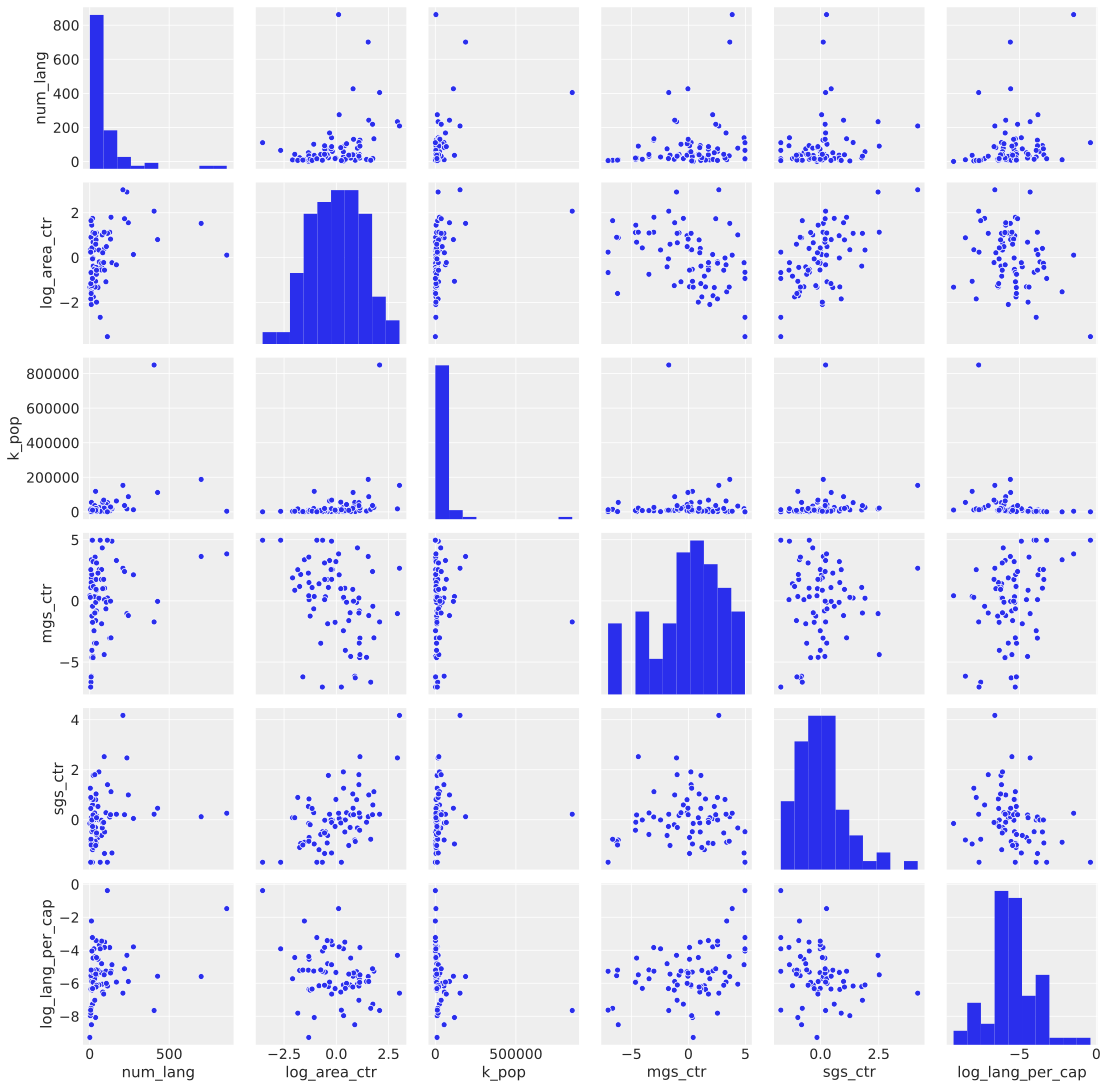

In [20]:
import seaborn as sns
sns.pairplot(d[["num_lang", "log_area_ctr", "k_pop", "mgs_ctr", "sgs_ctr", "log_lang_per_cap"]])

In [21]:
d.sort_values(by="area", ascending=False).head(5)

,country,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season,lang_per_cap,log_lang_per_cap,log_area,log_area_ctr,mgs_ctr,sgs_ctr
7,Brazil,209,8511965,153322,245,9.71,5.87,0.001363,-6.597961,15.956984,3.022073,2.668514,4.170811
2,Australia,234,7713364,17336,134,6.00,4.17,0.013498,-4.305220,15.858465,2.923554,-1.041486,2.470811
28,India,405,3287590,849638,218,5.32,1.92,0.000477,-7.648679,15.005666,2.070755,-1.721486,0.220811
60,Sudan,134,2505813,25941,43,4.02,2.82,0.005166,-5.265740,14.734124,1.799213,-3.021486,1.120811
0,Algeria,18,2381741,25660,102,6.60,2.29,0.000701,-7.262317,14.683342,1.748431,-0.441486,0.590811


In [22]:
d.sort_values(by="k_pop", ascending=False).head(5)

,country,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season,lang_per_cap,log_lang_per_cap,log_area,log_area_ctr,mgs_ctr,sgs_ctr
28,India,405,3287590,849638,218,5.32,1.92,0.000477,-7.648679,15.005666,2.070755,-1.721486,0.220811
29,Indonesia,701,1904569,187765,58,10.67,1.82,0.003733,-5.590438,14.459766,1.524856,3.628514,0.120811
7,Brazil,209,8511965,153322,245,9.71,5.87,0.001363,-6.597961,15.956984,3.022073,2.668514,4.170811
3,Bangladesh,37,143998,118745,20,7.40,0.73,0.000312,-8.073815,11.877555,-1.057356,0.358514,-0.969189
46,Nigeria,427,923768,112163,24,7.00,2.16,0.003807,-5.570924,13.736217,0.801306,-0.041486,0.460811


In [23]:
d.sort_values(by="mean_growing_season", ascending=False).head(5)

,country,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season,lang_per_cap,log_lang_per_cap,log_area,log_area_ctr,mgs_ctr,sgs_ctr
26,Guyana,14,214969,800,5,12.00,1.22,0.017500,-4.045554,12.278249,-0.656662,4.958514,-0.479189
56,Solomon Islands,66,28896,3301,1,12.00,0.00,0.019994,-3.912326,10.271459,-2.663452,4.958514,-1.699189
67,Vanuatu,111,12189,163,4,12.00,0.00,0.680982,-0.384220,9.408289,-3.526622,4.958514,-1.699189
61,Suriname,17,163265,429,2,12.00,0.00,0.039627,-3.228244,12.003130,-0.931781,4.958514,-1.699189
36,Malaysia,140,329749,18333,63,11.92,0.37,0.007637,-4.874815,12.706087,-0.228824,4.878514,-1.329189


---

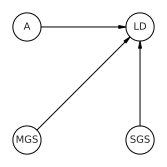

In [24]:
dag = CausalGraphicalModel(
    nodes=["MGS", "SGS", "A", "LD"],
    edges=[
        ("MGS", "LD"), ("SGS", "LD"), ("A", "LD")
    ]
)
pgm = daft.PGM()
coordinates = {"MGS": (0, 0), "SGS": (2, 0), "A": (0, 2), "LD": (2, 2)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()

# all_independencies = wd_dag.get_all_independence_relationships()
# for s in all_independencies:
#     if all(
#         t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
#         for t in all_independencies
#         if t != s
#     ):
#         print(s)

In [25]:
def model1(log_lang_per_cap=None, mgs_ctr=None):
    a = numpyro.sample("a", dist.Normal(-5, 5))
    bMGS = numpyro.sample("bMGS", dist.Normal(0,.5))

    mu = numpyro.deterministic(
        "mu", a + bMGS * mgs_ctr
    )
    sigma = numpyro.sample("sigma", dist.Exponential(.5))
    numpyro.sample("log_lang_per_cap", dist.Normal(mu, sigma), obs=log_lang_per_cap)

data = dict(
    mgs_ctr=d.mgs_ctr.values,
    log_lang_per_cap=d.log_lang_per_cap.values
)

model = model1
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az_1 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:06<00:00, 248.38it/s, 7 steps of size 8.78e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.45      0.17     -5.45     -5.72     -5.17    972.85      1.00
      bMGS      0.17      0.06      0.17      0.07      0.26    796.09      1.00
     sigma      1.45      0.12      1.44      1.26      1.64   1036.00      1.00

Number of divergences: 0


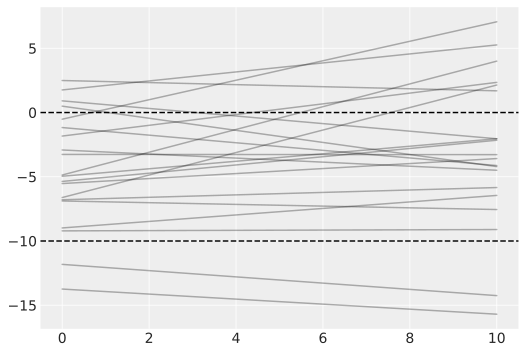

In [26]:
x = jnp.linspace(0, 10, 100)
mu = Predictive(model1, num_samples=100, return_sites=["mu"]).get_samples(random.PRNGKey(2),mgs_ctr=x)["mu"]
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=-10, c="k", ls="--")#, lw=0.5)
for i in range(20):
    plt.plot(x, mu[i], "k", alpha=0.3)

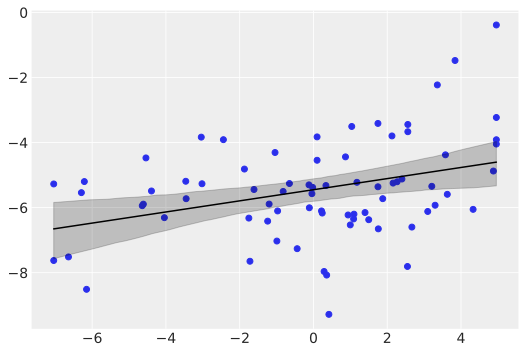

In [27]:
x = jnp.linspace(d.mgs_ctr.min(), d.mgs_ctr.max(), 100)

post_pred = Predictive(model1, post_samples, return_sites=["mu"]) \
    .get_samples(random.PRNGKey(3),mgs_ctr=x)["mu"]
mu_mean = jnp.mean(post_pred, axis=0)
mu_PI = jnp.percentile(post_pred, q=(1.5, 97.5), axis=0)

plt.scatter(d.mgs_ctr.values, d.log_lang_per_cap.values)
plt.plot(x, mu_mean, 'k')
plt.fill_between(x, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

In [28]:
def model2(log_lang_per_cap=None, mgs_ctr=None, log_area_ctr=None):
    a = numpyro.sample("a", dist.Normal(-5, 5))
    bMGS = numpyro.sample("bMGS", dist.Normal(0,.25))
    bA = numpyro.sample("bA", dist.Normal(0,.5))

    mu = numpyro.deterministic(
        "mu", a + bMGS * mgs_ctr + bA * log_area_ctr
    )
    sigma = numpyro.sample("sigma", dist.Exponential(.5))
    numpyro.sample("log_lang_per_cap", dist.Normal(mu, sigma), obs=log_lang_per_cap)

In [29]:
data = dict(
    mgs_ctr=d.mgs_ctr.values,
    log_area_ctr=d.log_area_ctr.values,
    log_lang_per_cap=d.log_lang_per_cap.values
)

model = model2
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

az_2 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:06<00:00, 223.48it/s, 7 steps of size 7.41e-01. acc. prob=0.89]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.45      0.16     -5.45     -5.70     -5.18   1008.96      1.00
        bA     -0.19      0.14     -0.19     -0.39      0.06    945.53      1.00
      bMGS      0.14      0.05      0.14      0.05      0.22    884.91      1.00
     sigma      1.43      0.12      1.42      1.25      1.64    904.22      1.00

Number of divergences: 0


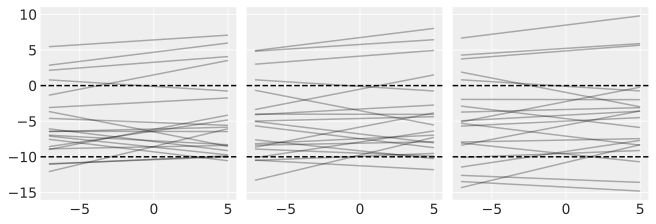

In [30]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
fixed = {
    # 'sd_growing_season': (
    #     d.sd_growing_season.min(), d.sd_growing_season.mean(), d.sd_growing_season.max()
    # ),
    'log_area_ctr': (
        d.log_area_ctr.min(), d.log_area_ctr.mean(), d.log_area_ctr.max()
    ),
}
for ax, idx in zip(axes, range(0, 3)):
    x = jnp.linspace(d.mgs_ctr.min(), d.mgs_ctr.max(), 100)

    mu = Predictive(model2, num_samples=100, return_sites=["mu"]).get_samples(
        random.PRNGKey(5),
        mgs_ctr=x,
        log_area_ctr=fixed['log_area_ctr'][idx],
    )["mu"]
    ax.axhline(y=0, c="k", ls="--")
    ax.axhline(y=-10, c="k", ls="--")#, lw=0.5)
    ax.title.set_text("")

    for i in range(20):
        ax.plot(x, mu[i], "k", alpha=0.3)

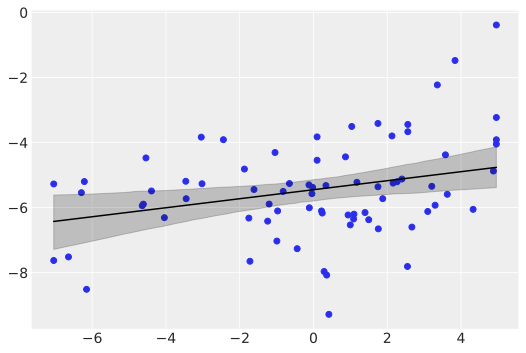

In [31]:
x = jnp.linspace(d.mgs_ctr.min(), d.mgs_ctr.max(), 100)

post_pred = Predictive(model2, post_samples, return_sites=["mu"]) \
    .get_samples(random.PRNGKey(3), mgs_ctr=x, log_area_ctr=0)["mu"]
mu_mean = jnp.mean(post_pred, axis=0)
mu_PI = jnp.percentile(post_pred, q=(1.5, 97.5), axis=0)

plt.scatter(d.mgs_ctr.values, d.log_lang_per_cap.values)
plt.plot(x, mu_mean, 'k')
plt.fill_between(x, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

In [32]:
az.compare({"az_1": az_1, "az_2": az_2}, ic="waic", scale="deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
az_2,0,267.314,4.40128,0,0.525017,14.3666,0,True,deviance
az_1,1,267.5,3.39525,0.185986,0.474983,14.8753,3.22563,True,deviance


In [33]:
pareto_k = az.loo(az.from_numpyro(mcmc), pointwise=True).pareto_k.values
d[['country']].assign(pareto_k=pareto_k).sort_values(by='pareto_k', ascending=False).head(10)

,country,pareto_k
67,Vanuatu,0.434733
17,Cuba,0.341694
2,Australia,0.304795
19,Egypt,0.294701
59,Sri Lanka,0.277574
27,Honduras,0.268884
60,Sudan,0.257550
26,Guyana,0.249887
70,Yemen,0.247554
47,Oman,0.246094


In [34]:
def model3(log_lang_per_cap=None, mgs_ctr=None, sgs_ctr=None):
    a = numpyro.sample("a", dist.Normal(-5, 5))
    bM = numpyro.sample("bM", dist.Normal(0,.25))
    bS = numpyro.sample("bS", dist.Normal(0,.25))
    bMS = numpyro.sample("bMS", dist.Normal(0,.25))

    mu = numpyro.deterministic(
        "mu", a + bM * mgs_ctr + bS * sgs_ctr + bMS * mgs_ctr * sgs_ctr
    )
    sigma = numpyro.sample("sigma", dist.Exponential(.5))
    numpyro.sample("log_lang_per_cap", dist.Normal(mu, sigma), obs=log_lang_per_cap)

In [35]:
data = dict(
    mgs_ctr=d.mgs_ctr.values,
    sgs_ctr=d.sgs_ctr.values,
    log_lang_per_cap=d.log_lang_per_cap.values
)

model = model3
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples, **data)

sample: 100%|██████████| 1500/1500 [00:07<00:00, 207.01it/s, 3 steps of size 6.89e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.45      0.15     -5.45     -5.72     -5.23   1179.76      1.00
        bM      0.11      0.06      0.11      0.02      0.20    654.38      1.00
       bMS     -0.11      0.05     -0.11     -0.18     -0.03    861.98      1.00
        bS     -0.26      0.13     -0.26     -0.46     -0.06   1035.01      1.00
     sigma      1.36      0.11      1.35      1.19      1.55   1207.50      1.00

Number of divergences: 0


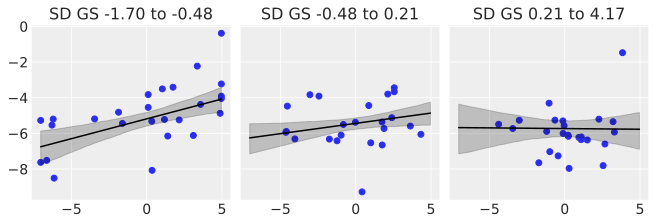

In [76]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row

# segment each non-plotted variable
sgs_ctr_breaks = d.sgs_ctr.quantile([0,1/3,2/3,1]).values
sgs_ctr_bounds = [(breaks[i], breaks[i+1]) for i in range(3)]

for ax, seg in zip(axes, range(0, 3)):
    x = jnp.linspace(d.mgs_ctr.min(), d.mgs_ctr.max(), 100)
    lwr, upr = sgs_ctr_bounds[seg]
    dseg = d[((seg == 0) | (d.sgs_ctr > lwr)) & (d.sgs_ctr <= upr)]
    
    post_pred = Predictive(model3, post_samples, return_sites=["mu"]).get_samples(
        random.PRNGKey(3), mgs_ctr=x, sgs_ctr=dseg.sgs_ctr.mean() # get mean for group
    )["mu"]
    mu_mean = jnp.mean(post_pred, axis=0)
    mu_PI = jnp.percentile(post_pred, q=(1.5, 97.5), axis=0)

    ax.scatter(dseg.mgs_ctr.values, dseg.log_lang_per_cap.values)
    ax.plot(x, mu_mean, 'k')
    ax.fill_between(x, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
    ax.title.set_text(f"SD GS {lwr:4.2f} to {upr:4.2f}")

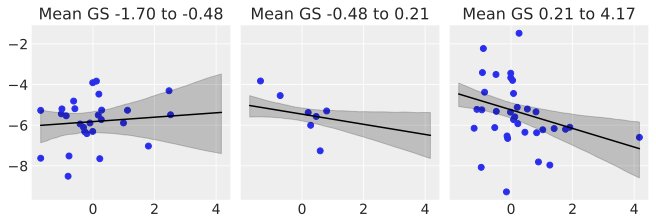

In [77]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row

# segment each non-plotted variable
mgs_ctr_breaks = d.mgs_ctr.quantile([0,1/3,2/3,1]).values
mgs_ctr_bounds = [(breaks[i], breaks[i+1]) for i in range(3)]

for ax, seg in zip(axes, range(0, 3)):
    x = jnp.linspace(d.sgs_ctr.min(), d.sgs_ctr.max(), 100)
    lwr, upr = mgs_ctr_bounds[seg]
    dseg = d[((seg == 0) | (d.mgs_ctr > lwr)) & (d.mgs_ctr <= upr)]
    
    post_pred = Predictive(model3, post_samples, return_sites=["mu"]).get_samples(
        random.PRNGKey(3), sgs_ctr=x, mgs_ctr=dseg.mgs_ctr.mean() # get mean for group
    )["mu"]
    mu_mean = jnp.mean(post_pred, axis=0)
    mu_PI = jnp.percentile(post_pred, q=(1.5, 97.5), axis=0)

    ax.scatter(dseg.sgs_ctr.values, dseg.log_lang_per_cap.values)
    ax.plot(x, mu_mean, 'k')
    ax.fill_between(x, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
    ax.title.set_text(f"Mean GS {lwr:4.2f} to {upr:4.2f}")